# Introduction to Markov Chain Monte Carlo

## Takeaways and objectives from this notebook
2. Basic ideas behind MCMC and convergence conditions in a (simplified) discrete universe.
3. The detailed balance condition.

## Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) is a method of generating **dependent** samples instead of the **independent** samples generated by Monte Carlo.

There are a few intuitive ways we can think about MCMC:
- as a method "learning" from past samples and moving toward better samples more often than not, or preferentially staying in high-density regions of the space
- as a method of rejection sampling where our proposal distribution is adaptive (typically centered on the last sample) instead of fixed as in Monte Carlo rejection sampling

For a more mathematical overview of MCMC theory mixed with practical tips, consult [Geyer](http://www.mcmchandbook.net/HandbookChapter1.pdf) [1].  For another, rather refreshing take that emphasizes graph theory, read the blog of [Jeremy Kun](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/) [2].  In this notebook, we will follow the accessible introduction for machine learners by [Andrieu et al.](http://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf) [3], which also discusses some of the exciting history around the development of the MCMC approach.  We remind readers again of the historic note by Metropolis [4].

Finally we recommend listening to two talks [5,6] by Nando de Freitas for the Machine learning course at University of British Columbia.  These talks present MCMC in an intuitive way.

### A side note about Markov Chains
Note that if you remember the theory of Markov Chains from your studies, chances are that your university courses solved a different problem that what we encounter here.

A typical question about Markov chains would be: given a transition probability matrix $P$, does there exist an equilibrium/stationary distribution (independent of a starting position) of the Markov Chain? If so, what is it?

The entire theory of MCMC for inference approaches the problem from the **opposite direction**.  We know what we want the stationary distribution of the Markov Chain to be: it should be the posterior distribution of the model that we built! The objective of MCMC theory is then to **design an algorithm (called a sampler)** that is associated with a Markov Chain such that its stationary distribution is the model posterior.

### Initial developments following [3]
We discuss some elements of Markov chains to support further developments.  It is beneficial to focus on Markov chains on finite state spaces.

Let $x_i \in {\cal X}$ be the state of a stochastic process at time $i$ with ${\cal X}$ a finite set.  The stochastic process $\{x_i\}_1^\infty$ is a Markov chain if
$$p(x_i|x_{i-1}, x_{i-2}, ..., x_1) = T(x_i|x_{i-1}),$$

with $T$ referred to as a *stochastic transition matrix*.  The state $x_i$ is thus conditionally independent of all states $x_{i-2}, ..., x_1$ given $x_{i-1}$.

The chain is *homogeneous* if $T(x_i|x_{i-1})$ does not depend on the index $i$, or in other words, $T$ is constant in time.

Given any starting point, the chain will converge to a *stationary/equilibrium/invariant* distribution $p(x)$ if $T$ has the following properties:
- *irreducibility* for any state in the Markov chain, there is a positive probability of visiting other states and
- *aperiodicity* the chain will not get trapped in a cycle.

We will demonstrate examples of such behavior later.

What we need to do is construct a $T$ such that our selected $p(x)$ becomes the invariant distribution. A **sufficient** but not necessary condition to ensure that a particular $p(x)$ is the desired invariant distribution is the **detailed balance** condition

$$p(x_i)T(x_{i-1}|x_i) = p(x_{i-1})T(x_i|x_{i-1}).$$

If we sum both sides over $x_{i-1}$, we get

$$p(x_i) = \sum_{x_{i-1}} p(x_{i-1})T(x_i|x_{i-1}).$$

**Note**: writing the last equation in vector form, we have $p^T = p^TT$, indicating that $p$ is a left eigenvector of the matrix $T$ with eigenvalue 1. This (and other properties) is actually guaranteed by the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem) for stochastic matrices.  Among the interesting properties is that all other eigenvalues have absolute value less than 1.  From this we can observe that second largest eigenvalue will determine the convergence rate, since by repeated multiplication by $T$ we have that it's eigenvector will be the slowest in being damped to zero.

If the matrix $T$ satisfies the above equation, we have built a MCMC sampler as per the definition above.

## Examples

In the following, we construct several variants of a very simple process, the Markov random walk over 8 possible states. Note that here we are approaching the Markov chain problem from an academic perspective to obtain intuition and perspective.  We will obtain the stationary distribution via an analytic solution (by computing the eigenvector) and compare to simulation.

1. Irreducible and aperiodic chain
2. Reducible chain (cannot reach all parts of the state space)
3. Periodic chain (gets trapped in periodic solution)

Below we specify a transition matrix, which we use to sample the next state given the current state.  If the current state is e.g. 3, then we pick the 4th column (states start at zero) from $T$ and select the next state given the probabilities in that column.  The correct column thus specifies a **proposal distribution** and the proposal is always accepted by the chain.  The proposal distribution depends on the current state and is in some sense adaptive compared to our proposal distribution in the **rejection sampling** exercise which was fixed.

In [1]:
import numpy as np

# this transition matrix will allow us to pick out the next state given an input state
T = np.array([[0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
              [0.5 , 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
              [0.  , 0.25, 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ],
              [0.  , 0.  , 0.25, 0.5 , 0.25, 0.  , 0.  , 0.  ],
              [0.  , 0.  , 0.  , 0.25, 0.5 , 0.25, 0.  , 0.  ],
              [0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.25, 0.  ],
              [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 ],
              [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 ]])

In [2]:
# we need to write a function that will pick the next state given the current state and the (fixed) transition matrix T
# in our homogeneous chain
def next_state(T, c):
    u = np.random.uniform()
    Tc = T[:,c]
    ns = len(Tc)
    n, s = 0, Tc[0]
    while u > s and n < ns-1:
        n += 1
        s += Tc[n]
    return n

# This function performs the markov chain simulation according to our transition probability. 
def run_markov_chain(T, state0, num_steps):
    state_now = state0
    state_memory = [state_now]

    for i in range(num_steps):
        state_now = next_state(T, state_now)
        state_memory.append(state_now)

    return state_memory

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_chain_states(state_memory, title):
    f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[9, 1]}, figsize=(16,4))
    ax0.plot(state_memory, 'o-', markersize=3)
    ax0.set_title('Markov chain state evolution: irreducible/aperiodic')
    ax1.hist(state_memory, bins = np.arange(9)-0.5, orientation='horizontal', density=True)
    ax0.set_ylim([0, 8])
    ax1.set_ylim([-0.5, 7.5])
    f.tight_layout()

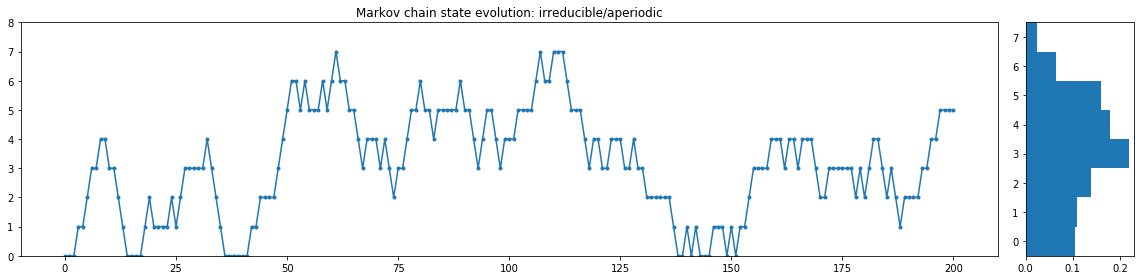

In [4]:
state_memory = run_markov_chain(T, 0, 200)

plot_chain_states(state_memory, 'Markov chain state evolution: irreducible/aperiodic')

In the plot above we see the trace (same as the `Trace` object in PyMC3) of the Markov chain.  In PyMC3, this would be stored in the `Trace` or `MultiTrace` object.  Observe that for a few hundred samples, the distribution of varies quite a bit if we rerun the simulation.

Below we compare the result to the analytical solution based on eigenvector decomposition.

### Analytical treatment

Note that we can recover the third column by matrix multiplication assuming that we indicate the third state by a vector $p=[0,0,0,1,0,0,0,0]^T$. Then we get the 4th column of $T$ by simply multiplying $Tp$.

The result gives us the probabilities of the next states given the current state.  This is true even if $p$ already reflects a distribution of states, for example:

In [16]:
p = np.array([0, 0, 0.5, 0.5, 0, 0, 0, 0]).reshape(8,1)

# note that @ is matrix multiplication in python
T @ p

# the result below gives us the distribution of states in the next time step given the distribution in the current time step.

array([[0.   ],
       [0.125],
       [0.375],
       [0.375],
       [0.125],
       [0.   ],
       [0.   ],
       [0.   ]])

If this is true and we assume our transition matrix corresponds to an irreducible and aperiodic chain, then we can compute the equilibrium distribution $p$ for which it is true that applying the transition matrix to it does not change it, so we require $Tp = p$.  This means that $p$ is a right eigenvector of $T$ with eigenvalue 1.  Let us compute the equilibrium distribution.

In [32]:
# Let us compute the analytical solution of the state distribution
V, E = np.linalg.eig(T)

# numpy.linalg.eig does not necessarily order eigenvalues by magnitude, let's do it here
ndx = np.argsort(Vr)[::-1]
Vr = Vr[ndx]
Er = Er[:,ndx]

# first eigenvalue should be one, rest should be smaller in abs value
print(V)

# first eigenvector is the eigenvector of probabilities
# (must be flipped if negative, eigvecs are determined up to multiplicative factor)
equilibrium_prob = E[:,0] / np.sum(E[:,0])

[ 1.00000000e+00  9.50484434e-01  8.11744901e-01  6.11260467e-01
  3.88739533e-01 -5.04948516e-17  4.95155660e-02  1.88255099e-01]


We can compare the analytical distribution to the probabilities of a very long chain.

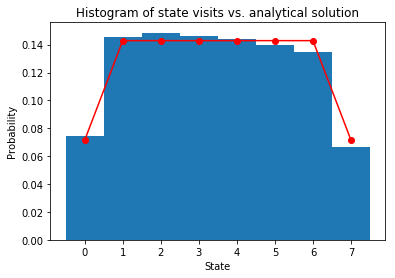

In [7]:
# Let us observe what happens when we sample many more states
sim1 = run_markov_chain(T, 0, 100000)

plt.hist(sim1, bins = np.arange(9) - 0.5, density=True)
plt.plot(equilibrium_prob, 'r-o')
plt.title('Histogram of state visits vs. analytical solution')
plt.xlabel('State')
_ = plt.ylabel('Probability')

### Exercise

1. Rerun the above simulations with fewer steps.
2. Change the intial conditions be on the boundary and in the middle.
3. Get a feel for the convergence behavior of the chain. Observe that with 100k steps the initial condition ceases to matter.

**Note**: although we have not proved this, the above chain is irreducible and aperiodic.

### Reducible chain
In a reducible chain, the transition matrix $T$ is such that we cannot reach all states regardless of initial value.  We provide an example reducible transition matrix here and invite the reader to run the Markov chain from different positions to confirm that the some parts of the space are unreachable. We can also see this by inspection.

A reducible chain means that given some initial conditions we are unable to reach certain states and thus there is no unique equilibrium distribution.  This is a problem because if we want to converge to and sample from our model posterior, this is a deal breaker.

In [27]:
Tr = np.array([[0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
              [0.5 , 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
              [0.  , 0.25, 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ],
              [0.  , 0.  , 0.25, 0.5 , 0.0 , 0.  , 0.  , 0.  ],
              [0.  , 0.  , 0.  , 0.0 , 0.5 , 0.25, 0.  , 0.  ],
              [0.  , 0.  , 0.  , 0.  , 0.0 , 0.5 , 0.25, 0.  ],
              [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 ],
              [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 ]])

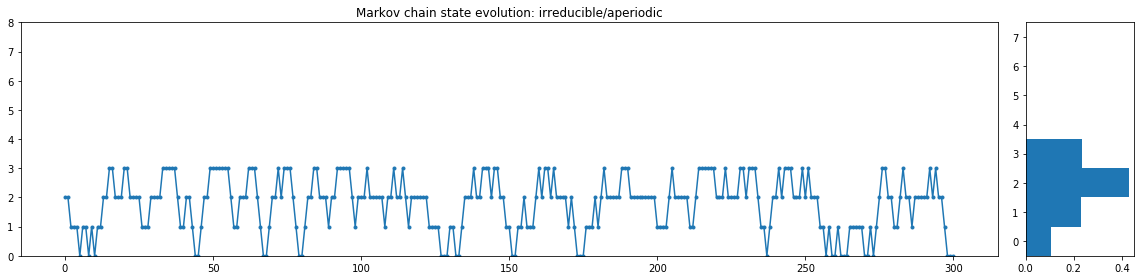

In [29]:
state_memory = run_markov_chain(Tr, 2, 300)
plot_chain_states(state_memory, 'Markov chain state evolution: reducible')

### Exercise

1. Modify the starting state above so that part of the state space is never visited.  Which states have this property?
2. Observe that no matter where you start, the system will get trapped in a region of the state space eventually. Identify the region.
3. Inspect the transition matrix. Can you identify the 'sink' region from the matrix? How?

### Periodic chain

In a periodic chain there is a non-zero probability that the chain will get stuck in a repeating loop, as in the next example.

In [12]:
## Periodic transition matrix
Tp = np.array([[0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
               [0.5 , 0.5 , 0.25, 0.  , 0. , 0.  , 0.  , 0.  ],
               [0.  , 0.25, 0.5 , 0.25, 0. , 0.  , 0.  , 0.  ],
               [0.  , 0.  , 0.25, 0.5 , 0.0, 0.  , 0.  , 0.  ],
               [0.  , 0.  , 0.  , 0.25, 0.0, 1.0 , 0.  , 0.  ],
               [0.  , 0.  , 0.  , 0.  , 1.0, 0.0 , 0.25, 0.  ],
               [0.  , 0.  , 0.  , 0.  , 0. , 0.0 , 0.5 , 0.5 ],
               [0.  , 0.  , 0.  , 0.  , 0. , 0.0 , 0.25, 0.5 ]])

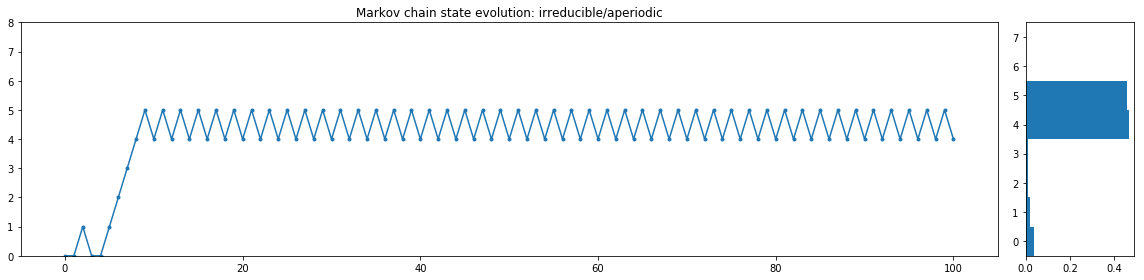

In [13]:
state_memory = run_markov_chain(Tp, 0, 100)
plot_chain_states(state_memory, 'Markov chain state evolution: periodic')

Note that in this case the chain gets trapped in a periodic solution that it can never escape.  Such a Markov chain would be useless for us.

### Exercises
1. Inspect the matrix to understand exactly what happens when the current state is 4 or 5.

## Conclusions
We have provided examples of Markov chains that should provide intuition about the requirements on the construction of working MCMC samplers.  The examples should not be interpreted as definitive, they are only examples of unwanted behavior.

We have not investigated the property of detailed balance that was mentioned in the introduction.  This will be analyzed in the next notebook in the context of the Metropolis sampler.

## References

1. Geyer, C. [Chapter 1: Introduction to Markov Chain Monte Carlo](http://www.mcmchandbook.net/HandbookChapter1.pdf) in Handbook of Markov Chain Monte Carlo, Chapman and Hall/CRC, 2011.
2. Kun, J. [Markov Chain Monte Carlo without all the bullshit](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/), 2015.
3. Andrieu C. and De Freitas, N, Doucet, A, Jordan, MI. [An introduction to MCMC for machine learning](http://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf). Machine Learning 50, 2003.
4. Nicholas Metropolis. [The Beginning of the Monte Carlo method](http://library.lanl.gov/cgi-bin/getfile?00326866.pdf). Los Alamos Science. 1987, pp. 125-130.
5. Nando de Freitas. [Machine learning - Importance sampling and MCMC I](https://www.youtube.com/watch?v=TNZk8lo4e-Q), University of British Columbia, 2013.
6. Nando de Freitas. [Machine learning - Markov chain Monte Carlo II](https://www.youtube.com/watch?v=sK3cg15g8FI), University of British Columbia, 2013.